In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optuna.distributions import CategoricalDistribution
%matplotlib inline
import seaborn as sns

%precision % .4f

import warnings

warnings.filterwarnings('ignore')



### Датасет и разведочный анализ
Сам [датасет](https://www.kaggle.com/datasets/anshulmehtakaggl/60k-responses-of-16-personalities-test-mbt).
В нем указаны ответы людей на тест по 16 типам личности.
![Типы личностей](pers.jpg)
Необходимо решить задачу кластеризации.

In [2]:
df = pd.read_csv('16P.csv', encoding='cp1252')
df = df.sample(10000)
df.head()

,Response Id,You regularly make new friends.,You spend a lot of your free time exploring various random topics that pique your interest,Seeing other people cry can easily make you feel like you want to cry too,You often make a backup plan for a backup plan.,"You usually stay calm, even under a lot of pressure","At social events, you rarely try to introduce yourself to new people and mostly talk to the ones you already know",You prefer to completely finish one project before starting another.,You are very sentimental.,You like to use organizing tools like schedules and lists.,...,You believe that pondering abstract philosophical questions is a waste of time.,"You feel more drawn to places with busy, bustling atmospheres than quiet, intimate places.",You know at first glance how someone is feeling.,You often feel overwhelmed.,You complete things methodically without skipping over any steps.,You are very intrigued by things labeled as controversial.,You would pass along a good opportunity if you thought someone else needed it more.,You struggle with deadlines.,You feel confident that things will work out for you.,Personality
33968,33968,0,-1,-1,1,2,2,-2,0,-1,...,1,0,0,0,-1,0,2,1,0,ESFJ
17500,17500,0,0,-1,-1,0,-2,1,0,-1,...,0,0,0,3,0,0,2,1,3,INFJ
22596,22596,0,0,0,2,1,-2,-3,0,2,...,0,-1,0,0,0,0,1,0,1,ENFJ
41437,41437,0,0,3,0,-1,3,-2,-1,3,...,0,-1,0,0,0,0,-1,0,-2,INFJ
53815,53815,0,0,-2,1,-2,-3,-1,1,1,...,0,2,0,2,0,0,1,0,-1,ENTP


In [3]:
df.isnull().sum()

Response Id                                                                                   0
You regularly make new friends.                                                               0
You spend a lot of your free time exploring various random topics that pique your interest    0
Seeing other people cry can easily make you feel like you want to cry too                     0
You often make a backup plan for a backup plan.                                               0
                                                                                             ..
You are very intrigued by things labeled as controversial.                                    0
You would pass along a good opportunity if you thought someone else needed it more.           0
You struggle with deadlines.                                                                  0
You feel confident that things will work out for you.                                         0
Personality                             

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 33968 to 33833
Data columns (total 62 columns):
 #   Column                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                                --------------  ----- 
 0   Response Id                                                                                                           10000 non-null  int64 
 1   You regularly make new friends.                                                                                       10000 non-null  int64 
 2   You spend a lot of your free time exploring various random topics that pique your interest                            10000 non-null  int64 
 3   Seeing other people cry can easily make you feel like you want to cry too                                             10000 non-null  int64 
 4   You of

Целевой признак имеет тип `object`, заменим на числа от 0 до 15.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Personality'] = le.fit_transform(df['Personality'])
df['Personality'].value_counts().sort_index()

0     627
1     618
2     622
3     594
4     636
5     606
6     637
7     669
8     679
9     610
10    606
11    612
12    637
13    626
14    620
15    601
Name: Personality, dtype: int64

Примерно одинаковое количество данных для каждого из типов личностей должно дать кластерам приблизительно одинаковый размер.

In [6]:
df.drop(['Response Id'], axis=1, inplace=True)

### Снижение размерности и визуализация

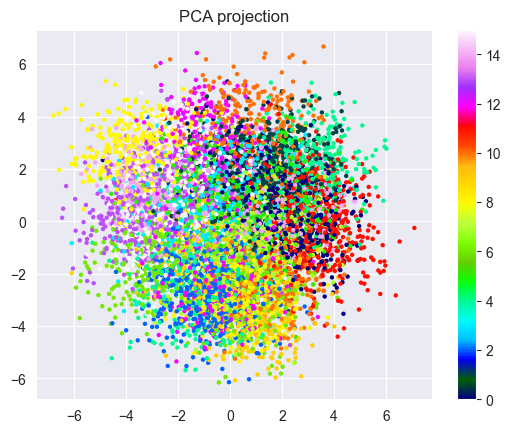

In [7]:
from sklearn.decomposition import PCA

X = df.drop(['Personality'], axis=1)
Y = df['Personality']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, s=10, cmap=plt.get_cmap('gist_ncar'), edgecolors='none')
plt.colorbar()
plt.title('PCA projection');

Разделение по кластерам довольно четкое по краям, но в середине смешивается.

CPU times: total: 13min 15s
Wall time: 1min 11s


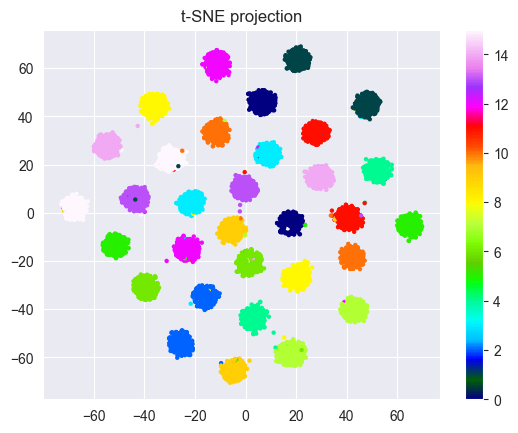

In [8]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=6)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, s=10, cmap=plt.get_cmap('gist_ncar'), edgecolors='none')
plt.colorbar()
plt.title('t-SNE projection');

С t-SNE разделение на группы визуально очень заметно, однако остаются выбросы. Также стоит отметить, что этих групп намного большее количество, чем 16.

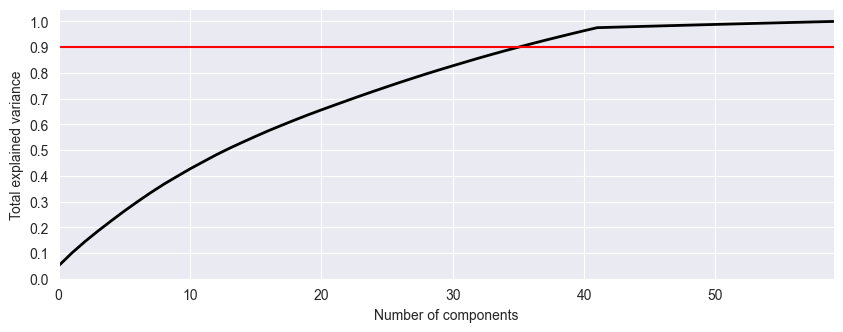

In [9]:
pca = PCA().fit(X)

plt.figure(figsize=(10, 3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 59)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')

30 вопросов достаточно для описания 80% дисперсии, уже 35 хватает для 90%. Для практически 100% - 40.
Так что размерность датасета должно быть можно сократить с 60 до 40 без потери информации. Используем это в дальнейшем при выборе метрик.

## Обучение моделей кластеризации
### Собственная реализация `K-Means`


In [10]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_random_state, check_scalar, check_array
from sklearn.base import BaseEstimator, ClusterMixin


class KMeansRealization(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None, max_iter=300):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]
        self.cluster_centers_ = X[self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :]

        for _ in range(max_iter):
            self.labels_ = self._get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

            if max_center_shift <= self.tol:
                break

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))

    def _get_labels(self, X):
        return np.argmin(
            np.linalg.norm(X[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


check_estimator(KMeansRealization())


### Обучение

In [11]:
%%time
Xs = [PCA(n_components=i).fit_transform(X) for i in [35, 40, 60]]
Xs.append(X)

CPU times: total: 109 ms
Wall time: 372 ms


In [12]:
import pathlib
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
import time
from sklearn import clone
import itertools

path = pathlib.Path("results.csv")


def cross_validation(estimator, param_distributions=None):
    if param_distributions is None:
        param_distributions = {}
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_distributions.items())
        )
    ]
    results = []
    for X in Xs:
        best_ari = None
        best_ami = None
        best_fmi = None
        for params in param_combs:
            e = clone(estimator).set_params(**params)
            start_time = time.perf_counter()
            pred = e.fit_predict(X)
            predict_time = (time.perf_counter() - start_time)
            ari = adjusted_rand_score(Y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, predict_time, params
            ami = adjusted_mutual_info_score(Y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, predict_time, params
            fmi = fowlkes_mallows_score(Y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, predict_time, params

        best_res = {
            "Clusterer": estimator.__class__.__name__,
            "Component number": X.shape[1],
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0],
            "Fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]])
        }
        print("\n".join("{}: \t{}".format(k, v) for k, v in best_res.items()))
        print("")
        results.append(best_res)
    results = pd.DataFrame(results)
    results.to_csv(path, mode="a", header=not path.exists())

In [13]:
%%time

cross_validation(KMeansRealization(n_clusters=10, random_state=80))

Clusterer: 	KMeansRealization
Component number: 	35
ARI: 	0.3449549530581606
AMI: 	0.5545395730692235
FMI: 	0.40931876612823215
Fit predict time, s: 	1.117734200000001

Clusterer: 	KMeansRealization
Component number: 	40
ARI: 	0.31971431146675794
AMI: 	0.5361705716452416
FMI: 	0.3857979408861383
Fit predict time, s: 	1.2063162999999975

Clusterer: 	KMeansRealization
Component number: 	60
ARI: 	0.32084274662094237
AMI: 	0.5427809727051913
FMI: 	0.3884829964821431
Fit predict time, s: 	1.2953253000000018

Clusterer: 	KMeansRealization
Component number: 	60
ARI: 	0.32079018455516806
AMI: 	0.5424068115910303
FMI: 	0.38841140801896096
Fit predict time, s: 	1.7444334000000055

CPU times: total: 4.27 s
Wall time: 5.56 s


In [14]:
%%time
from sklearn.cluster import KMeans

cross_validation(KMeans(n_clusters=10, random_state=80))

Clusterer: 	KMeans
Component number: 	35
ARI: 	0.30021320234414517
AMI: 	0.5251260568411034
FMI: 	0.36820457720782346
Fit predict time, s: 	0.543470599999992

Clusterer: 	KMeans
Component number: 	40
ARI: 	0.28639484511367114
AMI: 	0.5200598142768873
FMI: 	0.36050347198671
Fit predict time, s: 	0.5369168999999943

Clusterer: 	KMeans
Component number: 	60
ARI: 	0.2908110143096321
AMI: 	0.5203562718594806
FMI: 	0.3617518988117187
Fit predict time, s: 	0.6771081999999922

Clusterer: 	KMeans
Component number: 	60
ARI: 	0.29120443389492495
AMI: 	0.5210983190623416
FMI: 	0.36214644931140694
Fit predict time, s: 	0.6192259999999976

CPU times: total: 10.7 s
Wall time: 2.78 s


In [15]:
%%time
from sklearn.cluster import KMeans

cross_validation(KMeans(n_clusters=16, n_init='auto', random_state=0),
               param_distributions={"algorithm": ["lloyd", "elkan"]})

Clusterer: 	KMeans
Component number: 	35
ARI: 	0.39451482659692433
AMI: 	0.6384195233096057
FMI: 	0.43902108575913806
Fit predict time, s: 	0.05375490000000127

Clusterer: 	KMeans
Component number: 	40
ARI: 	0.4240765743666748
AMI: 	0.6554504832912377
FMI: 	0.46347817077352704
Fit predict time, s: 	0.0511872000000011

Clusterer: 	KMeans
Component number: 	60
ARI: 	0.4034404577004249
AMI: 	0.646187279267341
FMI: 	0.4439878146916415
Fit predict time, s: 	0.08711389999999615

Clusterer: 	KMeans
Component number: 	60
ARI: 	0.4145900699617233
AMI: 	0.654014436603603
FMI: 	0.4535122039862682
Fit predict time, s: 	0.13855780000000095

CPU times: total: 9.58 s
Wall time: 1.57 s


In [16]:
%%time
from sklearn.cluster import DBSCAN

cross_validation(DBSCAN(n_jobs=-1), param_distributions={
        "eps": [5, 10, 20],
        "min_samples": [1, 5, 10]})

Clusterer: 	DBSCAN
Component number: 	35
ARI: 	2.9409428712006144e-05
AMI: 	0.0018164944921322066
FMI: 	0.24997253574515477
Fit predict time, s: 	0.25463426666666084

Clusterer: 	DBSCAN
Component number: 	40
ARI: 	2.4007999510632487e-06
AMI: 	0.00016147804226970418
FMI: 	0.24997253574515477
Fit predict time, s: 	0.24692576666666355

Clusterer: 	DBSCAN
Component number: 	60
ARI: 	6.002004921107134e-07
AMI: 	4.037179967784911e-05
FMI: 	0.24997253574515477
Fit predict time, s: 	0.2818095000000085

Clusterer: 	DBSCAN
Component number: 	60
ARI: 	6.002004921107134e-07
AMI: 	4.037179967784911e-05
FMI: 	0.24997253574515477
Fit predict time, s: 	2.9676492000000017

CPU times: total: 4min 34s
Wall time: 2min 53s


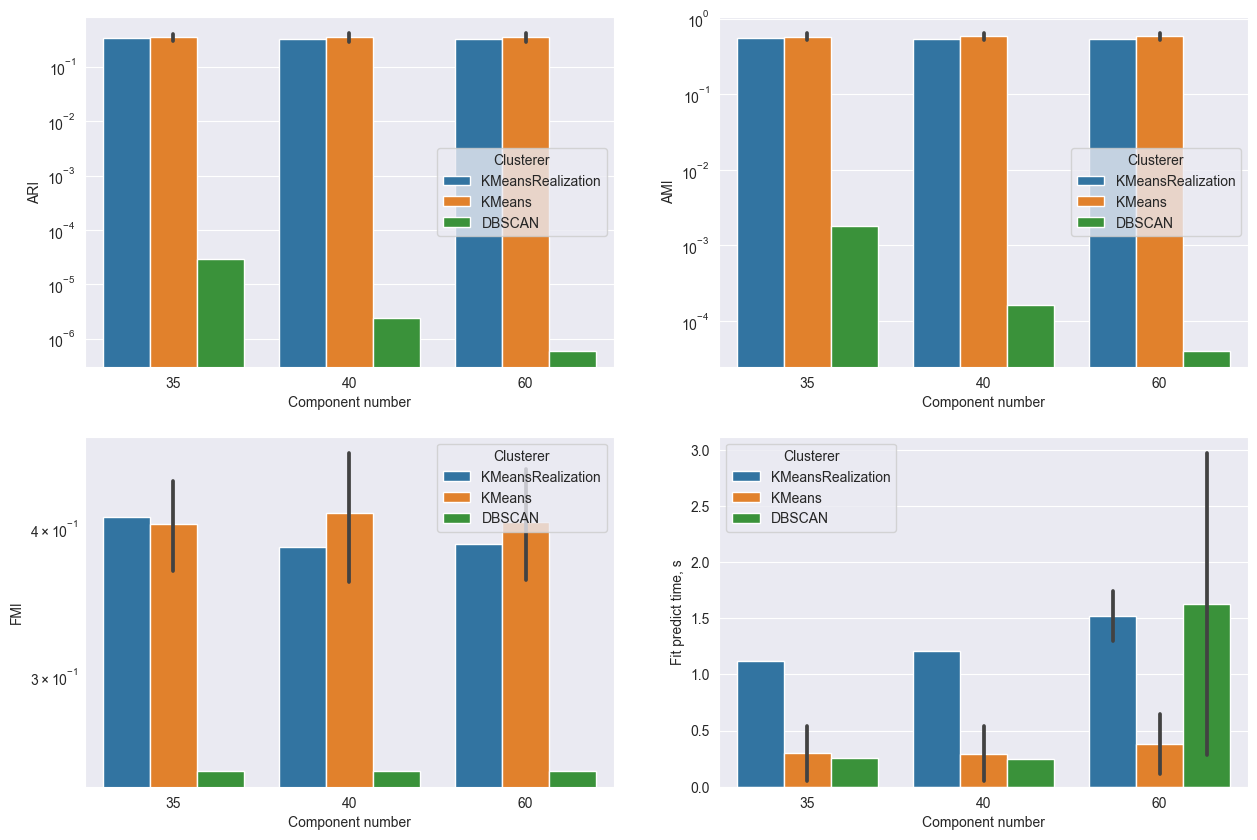

In [17]:
res = pd.read_csv(path)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for m_name, ax in zip(
        ["ARI", "AMI", "FMI", "Fit predict time, s"],
        axs.flatten(),
):
    if m_name != "Fit predict time, s":
        ax.set_yscale('log')
    sns.barplot(res, x="Component number", y=m_name, hue="Clusterer", ax=ax)

plt.show()

Наилучшую точность показал библиотечный алгоритм `KMeans`, хотя собственная его реализация уступает не так сильно. Но она сильно проигрывает во времени обучения. `DBSCAN` же показал сравнительно худшие результаты. А уменьшение размерности практически не повлияло на точность результатов. но уменьшило время обучения.